# Testing convergence and order of accuracy

[AMath 586, Spring Quarter 2019](http://staff.washington.edu/rjl/classes/am586s2019/) at the University of Washington. For other notebooks, see [Index.ipynb](Index.ipynb) or the [Index of all notebooks on Github](https://github.com/rjleveque/amath586s2019/blob/master/notebooks/Index.ipynb).

This notebook illustrates testing an ODE method to determine the order of accuracy. See Appendix A of [the textbook](http://staff.washington.edu/rjl/fdmbook/) and particularly A.6 for more discussion of this.

As an example, we investigate the effect of errors in starting values on the accuracy of a linear multistep method.

In [1]:
%matplotlib inline

In [2]:
from pylab import *

### 2-stage Adams-Bashforth

Suppose we apply the 2-stage Adams-Bashforth method to the ODE $u'(t) = Au(t)$ where 
$$A = \left[\begin{array}{rr}-2&0\\3&-1\end{array}\right].$$
with initial data $u(0) = [1, ~-1]^T$.

The exact solution is $u_1(t) = e^{-2t}, ~ u_2(t) = 2e^{-t} - 3e^{-2t}$.

In [3]:
t0 = 0.
eta = array([1., -1.])
A = array([[-2.,0.], [3.,-1.]])  # defines 2x2 matrix

# function f(u,t) (as a "lambda function")
f = lambda u,t: dot(A,u)  # matrix vector product

utrue = lambda t: array([exp(-2*t),  2*exp(-t)-3*exp(-2*t)])

### Implement Adams-Bashforth 2-step method

We implement this as a function that can be called to test the method both with different numbers of time steps `nsteps` between `t0` and `tfinal` (and hence vary $\Delta t$) and also with two different choices of *starting method.*   

For this two step method we need to specify not only $U^0 = \eta$, the initial condition for the ODE problem, but also the value $U^1$.  The 2-step Adams-Bashforth is "second order accurate" but we expect to see this accuracy in the global error only if we set $U^1$ appropriately, as described in the textbook in Section 5.9.3 and some of the examples of Chapter 6.  The parameter `ul_method` in this function allows testing either $U^1 = U^0$ if `ul_method = 0`, or $U^1 = U^0 + k\Delta t f(U^0)$ (the better choice that preserves second order accuracy).

In [4]:
def AB2(tfinal,nsteps, make_plot=True, u1_method=1):
    """
    2-step Adams-Bashforth method.
    u1_method defines how U^1 is computed from U^0 = eta.
    The default is ul_method=1, using Forward Euler.
    """
    
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    # since function f(u) = A*u is matrix-vector multiplication
    
    U = empty((2,nsteps+1))  
    U.fill(nan)
    
    U[:,0] = eta
    
    if u1_method == 0:
        U[:,1] = eta
    elif u1_method == 1:
        U[:,1] = eta + dt * f(U[:,0], t[0])  # Forward Euler 
    else:
        print("*** Unrecognized u1_method")
        return None
    
    # Main time-stepping loop:
    for n in range(0,nsteps-1):
        U[:,n+2] = U[:,n+1] + 0.5*dt * (-f(U[:,n], t[n]) + 3*f(U[:,n+1],t[n+1]))

    if make_plot:
        tfine = linspace(t0, tfinal, 1000)  # fine grid for plotting true solution
        ufine = utrue(tfine)
        figure(figsize=(8,4))
        plot(t,U[0,:],'bo', label='u0 - AB2', markersize=5)
        plot(tfine, ufine[0,:], 'b', label='u0 - true')
        plot(t,U[1,:],'ro', label='u1 - AB2', markersize=5)
        plot(tfine, ufine[1,:], 'r', label='u1 - true')
        legend()
        title('%i steps, dt = %7.4f' % (nsteps, dt))
    
    error = U - utrue(t)
    return error

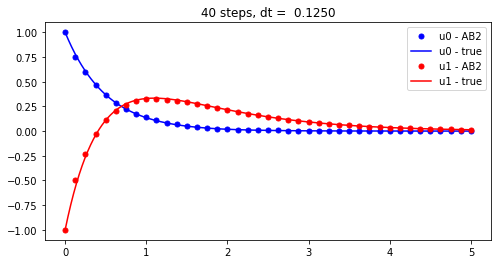

In [5]:
error = AB2(5., 40)

### Pick a time to examine the error

It's best to pick a time before the solution has decayed close to zero or the estimates of order might not be very good (since the error also decays exponentially to zero eventually).

In [6]:
utrue(1.)  # check the solution at t = 1

array([ 0.13533528,  0.32975303])

Solve the problem and print out the error at this time:

In [7]:
tfinal = 1.
error = AB2(tfinal, 10, make_plot=False)
print("The shape of error is ",error.shape)
print("Error at time %g is %s" % (tfinal, error[:,-1]))
print("One-norm of error is %g" % norm(error[:,-1], 1))
print("Max-norm of error is %g" % norm(error[:,-1], inf))

The shape of error is  (2, 11)
Error at time 1 is [ 0.00175985 -0.00607314]
One-norm of error is 0.00783298
Max-norm of error is 0.00607314


See how the error behaves as we incread the number of steps (decrease $\Delta t$):

In [8]:
for nsteps in [10,20,40,80]:
    error = AB2(tfinal, nsteps, make_plot=False)
    print("nsteps = %i, 1-norm of error = %12.10f" % (nsteps, norm(error[:,-1],1)))

nsteps = 10, 1-norm of error = 0.0078329834
nsteps = 20, 1-norm of error = 0.0019689688
nsteps = 40, 1-norm of error = 0.0004915716
nsteps = 80, 1-norm of error = 0.0001226725


Add some code to estimate the observed order of accuracy, by comparing the error with each value of `nsteps` to the error with half as many points.  Here we know the true solution, so we use the expressions from Appendix A.6.1 of the textbook:

In [9]:
previous_E = nan
for nsteps in [10,20,40,80]:
    error = AB2(tfinal, nsteps, make_plot=False)
    E = norm(error[:,-1],1)
    if nsteps>10:
        ratio = previous_E / E
        p = log(ratio)/log(2)
        print("nsteps = %i, ratio of errors = %12.10f, estimate p = %5.2f" % (nsteps, ratio, p))
    previous_E = E

nsteps = 20, ratio of errors = 3.9782162013, estimate p =  1.99
nsteps = 40, ratio of errors = 4.0054563843, estimate p =  2.00
nsteps = 80, ratio of errors = 4.0071856670, estimate p =  2.00


## Test for a sequence of N values and produce log-log plot

It is often easies to see how the error behaves by plotting the error vs. the number of time steps $N$ used, called `nsteps` in the code.  (Or vs. $\Delta t = T/N$ which would give a positive slope rather than a negative slope in the error plots.)

Since we expect the error to behave like $E(N) \approx C \Delta t^p = CT^p / N^p$ for some constant $C$ (depending on the particular ODE we solve) and value $p$ (the order of accuracy), it is easiest to observe the behavior if we produce a log-log plot, plotting $\log(E(N))$ vs. $\log(N)$.  We expect

$$
\log(E(N)) \approx \log(CT^p) - p\log(N)
$$

and hence linear in $\log(N)$ with slope $-p$.

Set the values of $N$:

In [10]:
nsteps_vals = [2**j for j in range(1,12)]  # "list comprehension" in Python
print("Will test with nsteps = ", nsteps_vals)

Will test with nsteps =  [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


### Test with good starting values 

We need starting values $U^0$ and $U^1$ for this 2-step method, where $U^0 = \eta$ is the initial data for the ODE but $U^1$ has to be computed.

First we use Forward Euler to compute $U^1$, which has an $O(k^2)$ error relative to the true value $u(t_1)$, and maintains the expected order of accuracy of the method.

We also plot a reference line with slope $-2$ since we hope this method is second order accuarate.  If so, we expect the plot of the error to be parallel to this (perhaps with some vertical shift depending on the value of $C$).

Text(0,0.5,'1-norm of error')

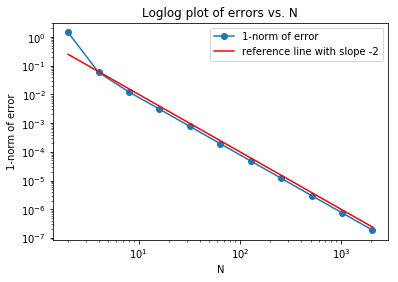

In [11]:
# Test with u1_method==1:  Euler for U^1:
E = empty(len(nsteps_vals))
for j,nsteps in enumerate(nsteps_vals):
    error = AB2(tfinal, nsteps, make_plot=False)
    E[j] = norm(error[:,-1],1)
    
loglog(nsteps_vals, E, '-o', label='1-norm of error')

nvals = array(nsteps_vals)  # turn into numpy array so we can square
slope2 = 1./(nvals**2)
loglog(nsteps_vals, slope2, 'r', label='reference line with slope -2')
legend()

title('Loglog plot of errors vs. N')
xlabel('N')
ylabel('1-norm of error')

### Test with poor starting value

Next we simply set $U^1 = U^0 = \eta$, which has an $O(k)$ error and reduces the entire solution to first order accuracy:

Text(0,0.5,'1-norm of error')

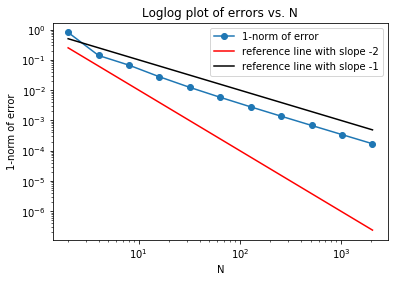

In [12]:
# Test with u1_method==0:  U^1 = U^0:
E = empty(len(nsteps_vals))
for j,nsteps in enumerate(nsteps_vals):
    error = AB2(tfinal, nsteps, make_plot=False, u1_method=0)
    E[j] = norm(error[:,-1],1)
    
loglog(nsteps_vals, E, '-o', label='1-norm of error')

nvals = array(nsteps_vals)  # turn into numpy array so we can square
slope2 = 1./(nvals**2)
loglog(nsteps_vals, slope2, 'r', label='reference line with slope -2')
slope1 = 1./nvals
loglog(nsteps_vals, slope1, 'k', label='reference line with slope -1')
legend()

title('Loglog plot of errors vs. N')
xlabel('N')
ylabel('1-norm of error')

**Note:** These tests are performed on a simple ODE with very smooth solution and so we see nearly linear behavior for all values of $N$ tested, beyond the smallest value $N=2$.

For a more realistic problem you probably would not see the nice linear behavior until $N$ is sufficiently large that the solution is well resolved.

Also for very large values of $N$, or for higher order methods with smaller $N$, the linear behavior will generally disappear once rounding errors begin to affect the solution.  The computations are done with 16-byte floating point numbers for which the "machine epsilon" is around $2\times 10^{-16}$, so we certainly cannot expact errors smaller than this and when over the course of thousands of time steps the rounding errors may grow to be larger so that the convergence curve saturates earlier.  This is true even if the method is zero-stable and so we expect convergence in exact arithmetic, but not computationally.